In [1]:
using LinearAlgebra
using Random
rng = MersenneTwister()
Random.seed!(rng, 2018)
output = false

false

In [2]:
# Size of the matrix
n = 64;

# Random initialization of matrix A
L = zeros(Float64,n,n)
U = zeros(Float64,n,n)
P = randperm(rng,n) # Randow row permutation
for i=1:n
    L[P[i],i] = 3 # Largest entry in the column
    L[P[i+1:n],i] = rand(rng, -2:2, n-i)
    U[i,i] = rand(rng, 1:2)
    U[i,i+1:n] = rand(rng, -2:2, n-i)
end
A = L * U
A0 = copy(A);
A0[1:6,1:6]

6×6 Array{Float64,2}:
  0.0   1.0   0.0   2.0    2.0   3.0
 -1.0  -3.0   1.0   4.0    3.0  -4.0
 -2.0  -1.0  -2.0   7.0    8.0   3.0
 -2.0   0.0  -7.0   3.0    2.0  -5.0
  2.0   1.0   3.0  -7.0  -12.0   4.0
 -1.0   0.0  -4.0   0.0   -1.0  -2.0

In [3]:
# Initializing the right-hand side
xe = rand(rng, 0:9, n) # This will be our solution
b = A * xe
b'

1×64 Adjoint{Float64,Array{Float64,1}}:
 405.0  441.0  235.0  265.0  90.0  …  538.0  -332.0  681.0  356.0  -286.0

In [4]:
include("../src/getrf.jl")

getrs (generic function with 3 methods)

In [5]:
A = copy(A0)
P0 = copy(P) # Save the reference permutation we initialized above
P = getrf!(A) 
if P == P0
    @info "getrf!: permutation is correct"
end

# Solve
x = getrs(A, P, b)
if x == xe # No roundoff error should occur for this example
    @info "getrf!: solution is correct"
end

┌ Info: getrf!: permutation is correct
└ @ Main In[5]:5
┌ Info: getrf!: solution is correct
└ @ Main In[5]:11


In [6]:
function flip_last_bit(A)
    B = Matrix{Float64}(undef,size(A))
    for j=1:size(A,2)
        for i=1:size(A,1)
            last_bit_flpd = xor( Int64( significand(A[i,j]) / eps(Float64) ), 1)
            B[i,j] = (2.0^exponent(A[i,j])) * (Float64(last_bit_flpd) * eps(Float64))
        end
    end
    return B
end

flip_last_bit (generic function with 1 method)

In [7]:
# Test flip_last_bit()
ntrial = 128
x = (1<<20) * ( randn(ntrial,ntrial) .- 0.5 )
# This test will fail if you modify flip_last_bit()
# You can still run the rest of the script safely
abs.(x - flip_last_bit(x)) == eps(Float64) * (2.0.^exponent.(x)) ? "TEST PASSED" : "TEST FAILED"

"TEST PASSED"

In [8]:
# Test the accuracy of the solver
# Random orthonormal matrix Q
X = rand(rng, n,n)
Q,R = qr(X)
b = randn(rng, n)
ntrial = 64
e = Matrix{Float64}(undef,2,ntrial)
for k=1:ntrial
    # Diagonal
    d = fill(1.0,n); d[n-k+1:end] = (1.0/2.0).^(1:k)
    A = Q * diagm(0 => d) * transpose(Q)
    # Make a small change
    B = flip_last_bit(A)    
    xe = A\b
    xf = B\b
    P = getrf!(A)
    x = getrs(A, P, b)
    e[1,k] = norm(x-xe) / norm(xe)
    e[2,k] = norm(xf-xe) / norm(xe)
end

In [9]:
include("../load_plot_pkg.jl")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11500203365184060320\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-8701809750971074791\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-11500203365184060320\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

plotToPDF (generic function with 1 method)

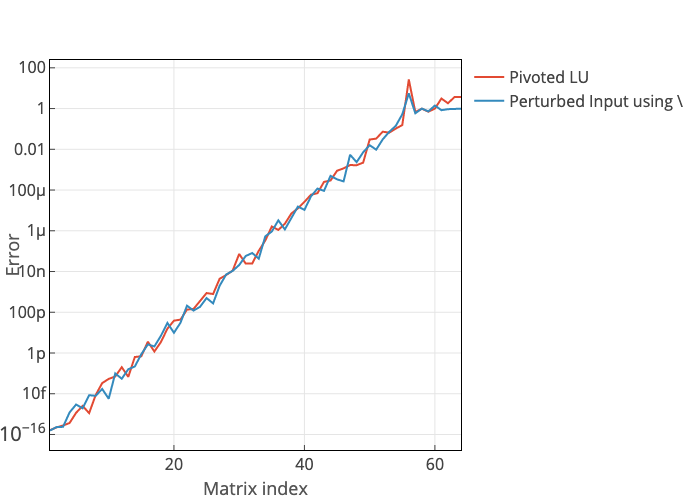

In [10]:
# Re-run all cells to get the plot below
t1 = scatter(x=1:n,y=e[1,:],name="Pivoted LU")
t2 = scatter(x=1:n,y=e[2,:],name="Perturbed Input using \\")
l = Layout(yaxis_type="log",xaxis_title="Matrix index",yaxis_title="Error",
    height=350,width=580)
p = plot([t1, t2],l)

In [11]:
if output
    plotToPDF(p,"fig_lu1")
end